In [1]:
import sys
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
except:
    pass
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import sys
import scipy
import random
import math
import skimage.io
import datetime
import open3d as o3d
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/balloon/"))  # To find local version
Stones_DIR = os.path.join(ROOT_DIR, "datasets/stones")

import coco

#from samples.blister import blister_mul_class
import stones_mul_class
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
STONES_MODEL_PATH = "../../samples/stones/mask_rcnn_stones_0062.h5"

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
sys.path.append('/opt/ros/kinetic/lib/python2.7/dist-packages')
from scoop.msg import stone_pose_hori
from scoop.msg import stone_pose_ver
import rospy
import geometry_msgs.msg
import time
import actionlib
from std_msgs.msg import String

Using TensorFlow backend.


In [2]:
rospy.init_node('stone_segmentation')

In [3]:
def make_directories():
    if not os.path.exists("JPEGImages/"):
        os.makedirs("JPEGImages/")
    if not os.path.exists("depth/"):
        os.makedirs("depth/")

In [4]:
# Start instance segmentation by Mask RCNN
class InferenceConfig(stones_mul_class.stonesConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
##config.display()
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
# Load weights trained on MS-COCO
model.load_weights(STONES_MODEL_PATH, by_name=True)
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = stones_mul_class.stonesDataset()
dataset.load_stones(Stones_DIR, "train")
# Must call before using the dataset
dataset.prepare()
#print("Image Count: {}".format(len(dataset.image_ids)))
#print("Class Count: {}".format(dataset.num_classes))
class_names = dataset.class_names






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.







In [5]:
def pixel_to_camera(pixel, intrin, depth):
    #depth = depth #/ 1000
    X = (pixel[0]-intrin[0]) * depth / intrin[2]
    Y = (pixel[1]-intrin[1]) * depth / intrin[3]
    return [X, Y]

In [6]:
# Compute position of mask center and rotation of mask
def get_mask_pose(depth_intrin, depth_array, m_c, mm_pair, max_d, min_d, surf_normal):
    #position = m_c
    #print('select mask center', m_c)
    m_c_dist = depth_array[m_c[1], m_c[0]]/1000
    if m_c_dist==0:
        center_z_set = []
        for i in range(-10,10):
            for j in range(-10,10):
                if depth_array[m_c[1]+i,m_c[0]+j]/1000 != 0:
                    center_z_set.append(depth_array[m_c[1]+i,m_c[0]+j]/1000)
        if center_z_set != []:
            m_c_dist=np.mean(center_z_set)  
        else:
            m_c_dist=0
    #position = rs.rs2_deproject_pixel_to_point(depth_intrin, m_c, m_c_dist)
    position = pixel_to_camera(m_c, depth_intrin, m_c_dist)
    min2max_vec = [mm_pair[0][0]-mm_pair[1][0], mm_pair[0][1]-mm_pair[1][1]]
    yaw = math.atan2(min2max_vec[1], min2max_vec[0])
    #print('test min2max_vec and yaw', min2max_vec, yaw)
    pitch = math.atan2(max_d-min_d, 0.023)
    if min2max_vec[0] > 0:
        yaw = math.pi/2 + yaw
    elif min2max_vec[0] < 0:
        if min2max_vec[1] > 0:
            yaw = -(3*math.pi/2-yaw)
        elif min2max_vec[1] < 0:
            yaw = -(-yaw-math.pi/2)
    if surf_normal == []:
        #print("surf normal empty")
        pose={
            'x':position[0],
            'y':position[1],
            'z':m_c_dist,
            'yaw':yaw,
            'pitch':pitch,
            'normal':surf_normal
        }
    else:
        pose={
            'x':position[0],
            'y':position[1],
            'z':m_c_dist,
            'yaw':yaw,
            'pitch':pitch,
            'normal':surf_normal
        }
    return pose

In [7]:
def get_dir_depth_outer(depth_array, m_c, mm_pair):
    pixel_radius=max(math.sqrt((mm_pair[0][0]-m_c[0])**2+(mm_pair[0][1]-m_c[1])**2),math.sqrt((mm_pair[1][0]-m_c[0])**2+(mm_pair[1][1]-m_c[1])**2))
    dir_pixel_set=[]
    dir_pixel_set.append([m_c[0], m_c[1]+pixel_radius*1.4])
    dir_pixel_set.append([m_c[0]+pixel_radius*1.4*math.sqrt(2), m_c[1]+pixel_radius*1.4*math.sqrt(2)])
    dir_pixel_set.append([m_c[0]+pixel_radius*1.4, m_c[1]])
    dir_pixel_set.append([m_c[0]+pixel_radius*1.4*math.sqrt(2), m_c[1]-pixel_radius*1.4*math.sqrt(2)])
    dir_pixel_set.append([m_c[0], m_c[1]-pixel_radius*1.4])
    dir_pixel_set.append([m_c[0]-pixel_radius*1.4*math.sqrt(2), m_c[1]-pixel_radius*1.4*math.sqrt(2)])
    dir_pixel_set.append([m_c[0]-pixel_radius*1.4, m_c[1]])
    dir_pixel_set.append([m_c[0]-pixel_radius*1.4*math.sqrt(2), m_c[1]+pixel_radius*1.4*math.sqrt(2)])
    dir_depth=[]
    for i in range(len(dir_pixel_set)):
        center_z_set = []
        for i0 in range(-5,5):
            for j0 in range(-5,5):
                if depth_array[max(min(round(dir_pixel_set[i][1])+i0, 479), 0), max(min(round(dir_pixel_set[i][0])+j0, 639), 0)]/1000 != 0:
                    center_z_set.append(depth_array[max(min(round(dir_pixel_set[i][1])+i0, 479), 0), max(min(round(dir_pixel_set[i][0])+j0, 639), 0)]/1000)
        if center_z_set != []:
            center_z=np.mean(center_z_set)
        else:
            center_z=0
        dir_depth.append(center_z)
    return dir_depth

In [8]:
def get_dir_depth_inner(depth_array, m_c, mm_pair):
    pixel_radius=min(math.sqrt((mm_pair[0][0]-m_c[0])**2+(mm_pair[0][1]-m_c[1])**2),math.sqrt((mm_pair[1][0]-m_c[0])**2+(mm_pair[1][1]-m_c[1])**2))
    dir_pixel_set=[]
    dir_pixel_set.append([m_c[0], m_c[1]+pixel_radius*0.9])
    dir_pixel_set.append([m_c[0]+pixel_radius*0.9*math.sqrt(2), m_c[1]+pixel_radius*0.9*math.sqrt(2)])
    dir_pixel_set.append([m_c[0]+pixel_radius*0.9, m_c[1]])
    dir_pixel_set.append([m_c[0]+pixel_radius*0.9*math.sqrt(2), m_c[1]-pixel_radius*0.9*math.sqrt(2)])
    dir_pixel_set.append([m_c[0], m_c[1]-pixel_radius*0.9])
    dir_pixel_set.append([m_c[0]-pixel_radius*0.9*math.sqrt(2), m_c[1]-pixel_radius*0.9*math.sqrt(2)])
    dir_pixel_set.append([m_c[0]-pixel_radius*0.9, m_c[1]])
    dir_pixel_set.append([m_c[0]-pixel_radius*0.9*math.sqrt(2), m_c[1]+pixel_radius*0.9*math.sqrt(2)])
    dir_depth=[]
    for i in range(len(dir_pixel_set)):
        center_z_set = []
        for i0 in range(-5,5):
            for j0 in range(-5,5):
                if depth_array[max(min(round(dir_pixel_set[i][1])+i0, 479), 0), max(min(round(dir_pixel_set[i][0])+j0, 639), 0)]/1000 != 0:
                    center_z_set.append(depth_array[max(min(round(dir_pixel_set[i][1])+i0, 479), 0), max(min(round(dir_pixel_set[i][0])+j0, 639), 0)]/1000)
        if center_z_set != []:
            center_z=np.mean(center_z_set)
        else:
            center_z=0        
        dir_depth.append(center_z)
    return dir_depth

In [9]:
import time 

def generate_stone_pose(depth_image, depth_array, seg_result):
    depth_copy = depth_image.copy()     
    mask_store = 4
    mask_size = []
    mask_sequence_hori = []
    mask_sequence_ver = []
    mask_center = []
    max_min_pair = []
    dist_min = []
    dist_max = []
    depth_set = []
    count_h = 0
    count_v = 0
    points = []
    point_show = []
    points_ero = []
    point_show_ero = []
    kernel = np.ones((15,15),np.uint8)
    center_position_set = []
    box_set = []
    
    image_center = [depth_copy.shape[1]/2, depth_copy.shape[0]/2]
    for m in range(seg_result['masks'].shape[2]):
        if seg_result['scores'][m]<0.97:
            continue
        mask = seg_result['masks'][:,:,m]
        mask = mask.astype(np.uint8)
        edges = cv2.Canny(mask,0,1)
        if np.sum(mask)==0 or np.sum(mask)>10000:
            continue
        if seg_result['class_ids'][m]==1:
            distance = []
            edge_point = []
            min_candidate = []
            max_candidate = []
            count = 0
            dist_max_ = -100000
            max_index = [0, 0]
            dist_min_ = 100000
            min_index = [0, 0]
            depth_intrin = [321.8862609863281, 238.18316650390625, 612.0938720703125, 611.785888671875]
            #print(depth_intrin)
            overall_mask_x = []
            overall_mask_y = []
            point = [] # store pointcloud of each go stone
            point_ero = [] # store pointcloud of each eroded go stone
            edge_pixel_set = np.argwhere(edges == 255)
            edge_pixel_set_copy=edge_pixel_set.tolist()
            edge_pixel_set_copy2=edge_pixel_set.tolist()
            for i in range(len(edge_pixel_set_copy2)):
                if edge_pixel_set_copy2[i][0]>=depth_copy.shape[0] or edge_pixel_set_copy2[i][1]>=depth_copy.shape[1]:
                    edge_pixel_set_copy.remove(edge_pixel_set_copy2[i])
            edge_pixel_set=np.array(edge_pixel_set_copy)
            overall_mask_x = edge_pixel_set[:,1].tolist()
            overall_mask_y = edge_pixel_set[:,0].tolist()
            for index in edge_pixel_set:
                depth_copy[index[0],index[1]] = [0, 255, 0]
            edge_point = edge_pixel_set[:]
            edge_point[:, [0, 1]] = edge_point[:, [1, 0]]
            edge_point = edge_point.tolist()
            for edge_pixel in edge_pixel_set_copy:
                if depth_array[edge_pixel[0],edge_pixel[1]]/1000 > dist_max_ and depth_array[edge_pixel[0],edge_pixel[1]]/1000 != 0:
                    dist_max_ = depth_array[edge_pixel[0],edge_pixel[1]]/1000
                    max_index = [edge_pixel[1], edge_pixel[0]] 
                if depth_array[edge_pixel[0],edge_pixel[1]]/1000 < dist_min_ and depth_array[edge_pixel[0],edge_pixel[1]]/1000 != 0:
                    dist_min_ = depth_array[edge_pixel[0],edge_pixel[1]]/1000
                    min_index = [edge_pixel[1], edge_pixel[0]] 
            pixel_radius=max(math.sqrt((max_index[0]-np.mean(overall_mask_x))**2+(max_index[1]-np.mean(overall_mask_y))**2),math.sqrt((min_index[0]-np.mean(overall_mask_x))**2+(min_index[1]-np.mean(overall_mask_y))**2))        
            distance = math.sqrt((np.mean(overall_mask_x)-image_center[0])**2+(np.mean(overall_mask_y)-image_center[1])**2)
            distance_coefficient = max(min(1,-0.25*distance+3*0.25*pixel_radius+1),0)
            mask_eff_area=np.sum(mask)*distance_coefficient
            erosion = cv2.erode(mask,kernel,iterations = 3)
            mask_pixel_set = np.argwhere(mask == 1)
            mask_pixel_set_copy=mask_pixel_set.tolist()
            for i in mask_pixel_set:
                if i[0]>=depth_copy.shape[0] or i[1]>=depth_copy.shape[1]:
                    mask_pixel_set_copy.remove(i.tolist())
            for mask_pixel in mask_pixel_set_copy:
                i = mask_pixel[0]
                j = mask_pixel[1]
                xy = pixel_to_camera([j, i], depth_intrin, depth_array[i, j])
                point.append([xy[0], xy[1], depth_array[i, j]]) # add pointcloud
            erosion_pixel_set = np.argwhere(erosion == 1)
            erosion_pixel_set_copy=erosion_pixel_set.tolist()
            for i in erosion_pixel_set:
                if i[0]>=depth_copy.shape[0] or i[1]>=depth_copy.shape[1]:
                    erosion_pixel_set_copy.remove(i.tolist())
            for erosion_pixel in erosion_pixel_set_copy:
                i = erosion_pixel[0]
                j = erosion_pixel[1]
                xy = pixel_to_camera([j, i], depth_intrin, depth_array[i, j])
                point_ero.append([xy[0], xy[1], depth_array[i, j]]) # add pointcloud
            point_show = point_show + point # pointcloud for all go stone candidates
            points.append(point)
            point_show_ero = point_show_ero + point_ero # pointcloud for all eroded go stone candidates
            points_ero.append(point_ero)
        
            #print('another dist max min', dist_max_, dist_min_)
            cv2.circle(depth_copy,tuple(edge_point[0]), 5, (0,0,255), 2)
            max_min_pair.append([max_index, min_index])
            dist_max.append(dist_max_)
            dist_min.append(dist_min_)
            mask_center.append([int(round(np.mean(overall_mask_x))), int(round(np.mean(overall_mask_y))), count_h])
            cv2.circle(depth_copy,tuple(max_min_pair[count_h][0]), 5, (0,0,0), 2)
            cv2.circle(depth_copy,tuple(max_min_pair[count_h][1]), 5, (255,0,0), 2)
            cv2.circle(depth_copy,tuple(mask_center[count_h][:2]), 5, (255,0,0), 1)
            mask_size.append(mask_eff_area)
            mask_sequence_hori.append(mask)
            count_h = count_h + 1
            
        elif seg_result['class_ids'][m]==2:
            dist_min_ = 100000
            min_index = [0, 0]
            depth_intrin = [321.8862609863281, 238.18316650390625, 612.0938720703125, 611.785888671875]
            #print(depth_intrin)
            contours,_ = cv2.findContours(mask.copy(), 1, 2)
            cnt = contours[0]     
            for j in range(len(contours)):
                if(len(contours[j]) > len(cnt)):
                    cnt = contours[j]
            for index in cnt:
                depth_copy[index[0][1],index[0][0]] = [0, 0, 255] 
            hull = cv2.convexHull(cnt,returnPoints = True)
            rect = cv2.minAreaRect(hull)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(depth_copy, [box], 0, (0, 255, 0), 1)
            center_pixel = [np.mean(np.array(cnt)[:,0,1]), np.mean(np.array(cnt)[:,0,0])]
            center_z_set = []
            for i in range(-3,4):
                for j in range(-3,4):
                    if depth_array[round(center_pixel[0])+i,round(center_pixel[1])+j]/1000 != 0:
                        center_z_set.append(depth_array[round(center_pixel[0])+i,round(center_pixel[1])+j]/1000)
            
            center_z=np.mean(center_z_set)
            if center_z == 0:
                continue
            box_real = []
            for i in range(len(box)):
                box_real.append(pixel_to_camera([box[i][0], box[i][1]], depth_intrin, center_z))
            center_x = np.mean(np.array(box_real)[:,0])
            center_y = np.mean(np.array(box_real)[:,1])
            
            distance = math.sqrt((center_pixel[0]-image_center[0])**2+(center_pixel[1]-image_center[1])**2)
            center_position_set.append([center_x, center_y, center_z])
            distance_coefficient = max(min(2,0.02*distance-2),1)
            eff_depth=center_z*distance_coefficient
            depth_set.append(eff_depth)
            box_set.append(box_real)
            mask_sequence_ver.append(mask)
            count_v +=1  
    hori_mask_index = np.argsort(-np.array(mask_size))[0:mask_store]
    if center_position_set != []:
        ver_mask_index = np.argsort(np.array(depth_set))[0:mask_store]
    else:
        ver_mask_index = []
    
    plt.figure()
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.imshow(depth_copy)
    
    surf_normal_set = dict()
    # Generate surface normal
    for k in hori_mask_index:
        pcd_ero = o3d.geometry.PointCloud()
        pcd_ero.points = o3d.utility.Vector3dVector(points_ero[mask_center[k][2]])
        pcd_temp = o3d.geometry.PointCloud()
        pcd_temp.points = o3d.utility.Vector3dVector(point_show_ero)
        o3d.io.write_point_cloud("test_ros_ero.ply", pcd_temp)
        o3d.io.write_point_cloud("test_ros_ero_selected.ply", pcd_ero)
        downpcd = o3d.geometry.voxel_down_sample(pcd_ero, voxel_size=1)
        #print("Recompute the normal of the downsampled point cloud")
        o3d.geometry.estimate_normals(downpcd, search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=10, max_nn=30))
        #print("Normal as a numpy array")
    
        for i in range(np.asarray(downpcd.normals).shape[0]):
            if downpcd.normals[i][2] > 0:
                downpcd.normals[i][0] = -downpcd.normals[i][0]
                downpcd.normals[i][1] = -downpcd.normals[i][1]
                downpcd.normals[i][2] = -downpcd.normals[i][2]
    
        normals = np.asarray(downpcd.normals)
        surf_normal_set[k]=np.sum(normals, axis=0) / normals.shape[0]
    
    return [[get_mask_pose(depth_intrin, depth_array, mask_center[k], max_min_pair[mask_center[k][2]], dist_max[mask_center[k][2]], dist_min[mask_center[k][2]], surf_normal_set[k]), depth_copy, get_dir_depth_inner(depth_array, mask_center[k], max_min_pair[mask_center[k][2]]), get_dir_depth_outer(depth_array, mask_center[k], max_min_pair[mask_center[k][2]]), mask_sequence_hori[k]] for k in hori_mask_index], [[center_position_set[l], box_set[l], mask_sequence_ver[l]] for l in ver_mask_index]

In [10]:
is_detect = 0
img_index = 0
def img_index_callback(data):
    global img_index
    global is_detect
    
    #print(data.data)
    img_index = data.data
    is_detect = 1

In [11]:

rospy.Subscriber('/stone_img_index', String, img_index_callback)

In [12]:
#import time
#is_detect = 1

Processing 1 images
image                    shape: (480, 640, 3)         min:   11.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/terry/anaconda3/envs/tensorflow_GPU/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


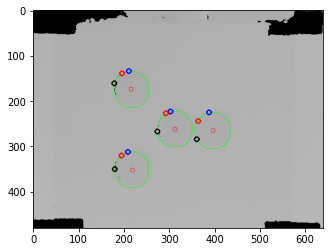

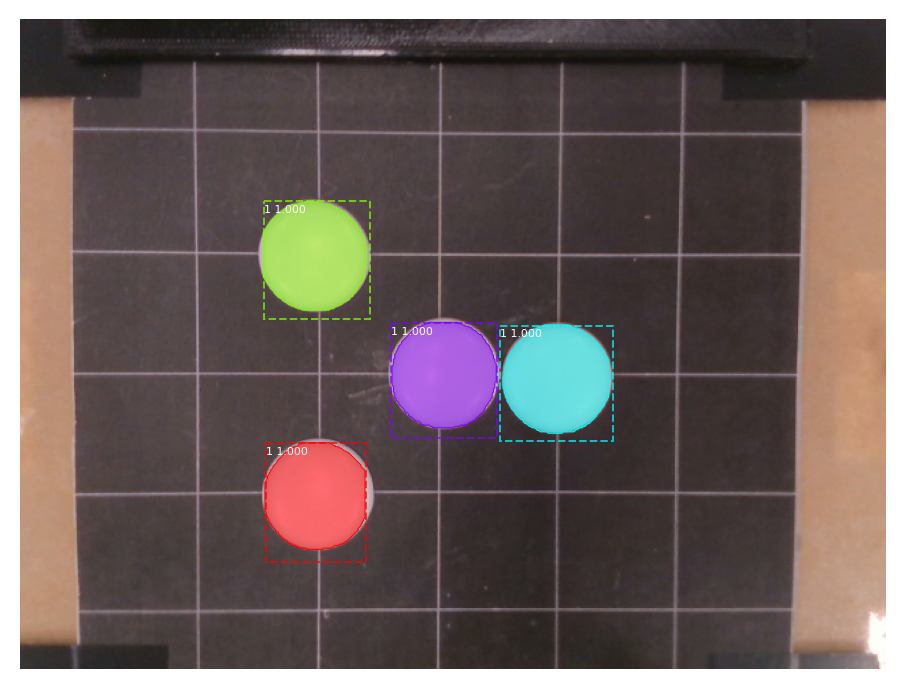

hori_stone_pose_msg is  header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
hori_Go_stone_number: 4
x: 0.021107159701914912
y: 0.007539394822167905
z: 0.172
yaw: -3.066732805879026
pitch: 0.29544083714371916
normal: [-0.19630634  0.07535421 -0.97329677]
dir_depth_inner: 
  - 0.17570000000000005
  - 0.17800000000000002
  - 0.17286999999999997
  - 0.177
  - 0.17251000000000002
  - 0.177
  - 0.17369999999999997
  - 0.17800000000000002
dir_depth_outer: 
  - 0.17801999999999998
  - 0.17854
  - 0.17800000000000002
  - 0.177
  - 0.177
  - 0.17607999999999993
  - 0.17201999999999995
  - 0.17800000000000002
hori_stone_pose_msg is  header: 
  seq: 0
  stamp: 
    secs: 0
    nsecs:         0
  frame_id: ''
hori_Go_stone_number: 4
x: -0.0024825450768236994
y: 0.006657032473686836
z: 0.171
yaw: -2.6981443171700548
pitch: 0.29544083714371916
normal: [-0.04414771  0.09397456 -0.99078534]
dir_depth_inner: 
  - 0.17536000000000002
  - 0.17800000000000002
  - 0.17256999999999992

KeyboardInterrupt: 

In [13]:
while (True):
    if(is_detect == 1):
        if os.path.exists('mask')==False:
            os.makedirs('mask')
        else:
            shutil.rmtree('mask')
            os.mkdir('mask')
        hori_pose_pub = rospy.Publisher('/hori_stone_pose', stone_pose_hori, queue_size=10)
        ver_pose_pub = rospy.Publisher('/ver_stone_pose', stone_pose_ver, queue_size=10)  
        #img_index = 3
        img_index = str(img_index)
        
        # instance segmentation
        image = skimage.io.imread("JPEGImages/"+img_index+".jpeg")
        
        # Run detection
        results = model.detect([image], verbose=1)
        # Visualize results
        r = results[0]
        
        #depth_image = cv2.imread("depth/"+img_index+".jpeg")
        depth_image = cv2.imread("depth/"+img_index+".jpeg")
        depth_array = np.load("./depth/"+img_index+".npy")
        hori_pose, ver_pose = generate_stone_pose(depth_image, depth_array, r)
        #plt.figure()
        #plt.rcParams['figure.figsize'] = [24, 12]
        #plt.imshow(depth_copy)
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
        if hori_pose == []:
            hori_stone_pose_msg = stone_pose_hori()
            hori_stone_pose_msg.hori_Go_stone_number = 0
            hori_pose_pub.publish(hori_stone_pose_msg)
            print('hori_stone_pose_msg is ', hori_stone_pose_msg)
        else:
            for i in range(len(hori_pose)):
                hori_stone_pose_msg = stone_pose_hori()
                hori_stone_pose_msg.hori_Go_stone_number = len(hori_pose)
                hori_stone_pose_msg.x = hori_pose[i][0]['x']
                hori_stone_pose_msg.y = hori_pose[i][0]['y']
                hori_stone_pose_msg.z = hori_pose[i][0]['z']   
                hori_stone_pose_msg.yaw = hori_pose[i][0]['yaw']
                hori_stone_pose_msg.pitch = hori_pose[i][0]['pitch']
                hori_stone_pose_msg.normal = hori_pose[i][0]['normal']
                hori_stone_pose_msg.dir_depth_inner = hori_pose[i][2]
                hori_stone_pose_msg.dir_depth_outer = hori_pose[i][3]
                np.save('mask/hori_'+str(i)+'.npy', hori_pose[i][4])  
                print('hori_stone_pose_msg is ', hori_stone_pose_msg)
                hori_pose_pub.publish(hori_stone_pose_msg)
        if ver_pose == []:
            ver_stone_pose_msg = stone_pose_ver()  
            ver_stone_pose_msg.ver_Go_stone_number = 0
            ver_pose_pub.publish(ver_stone_pose_msg)
            print('ver_stone_pose_msg is ', ver_stone_pose_msg)
        else:
            for j in range(len(ver_pose)):
                ver_stone_pose_msg = stone_pose_ver()            
                ver_stone_pose_msg.ver_Go_stone_number = len(ver_pose)
                ver_stone_pose_msg.x = float(ver_pose[j][0][0])
                ver_stone_pose_msg.y = float(ver_pose[j][0][1])
                ver_stone_pose_msg.z = float(ver_pose[j][0][2])
                ver_stone_pose_msg.box = str(ver_pose[j][1])
                np.save('mask/ver_'+str(j)+'.npy', ver_pose[j][2])
                print('ver_stone_pose_msg is ', ver_stone_pose_msg)
                ver_pose_pub.publish(ver_stone_pose_msg)
        is_detect = 0


In [ ]:
#print(depth_array[479,639]/1000)

In [33]:
#print(np.load('mask/hori_0.npy').shape)

(480, 640)
